In [1]:
# Import required libraries
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
print(tf.version)
# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)
import pandas as pd

Instructions for updating:
non-resource variables are not supported in the long term
<module 'tensorflow.compat.v1.version' from 'C:\\Users\\mattr\\anaconda3\\envs\\mc\\lib\\site-packages\\tensorflow\\_api\\v2\\compat\\v1\\version\\__init__.py'>


In [2]:
# path = Path('./tsla.csv')
tsla_df = pd.read_csv('./tsla.csv', index_col='Date', infer_datetime_format=True, parse_dates=True)

In [3]:
# drop empty column
tsla_df.drop(columns=['Down', 'RSI(14)', 'Up'], inplace=True)
# drop null values
tsla_df.dropna(inplace=True)
tsla_df

,Open,High,Low,Close,Volume
Date,,,,,
2022-04-06,1073.470,1079.00000,1027.700,1045.760,29782848
2022-04-05,1136.300,1152.86990,1087.300,1091.260,26691673
2022-04-04,1089.380,1149.91000,1072.530,1145.450,27392567
2022-04-01,1081.150,1094.75000,1066.640,1084.590,18087741
2022-03-31,1094.570,1103.13980,1076.641,1077.600,16330919
...,...,...,...,...,...
2010-07-06,4.000,4.00000,3.166,3.222,34337250
2010-07-02,4.600,4.62000,3.742,3.840,25701600
2010-07-01,5.000,5.18400,4.054,4.392,41118695


In [4]:
minmax = MinMaxScaler().fit(tsla_df.iloc[:, 3:4].astype('float32')) # Close index
df_log = minmax.transform(tsla_df.iloc[:, 3:4].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.849888
1,0.886978
2,0.931151
3,0.881541
4,0.875843


In [5]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
tsla_df.shape, df_train.shape, df_test.shape

((2965, 5), (2935, 1), (30, 1))

In [6]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.nn.rnn_cell.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [7]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [8]:
def forecast():
    tf.compat.v1.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(tsla_df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    return deep_future[-test_size:]

In [9]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\mattr\AppData\Local\Temp\ipykernel_14236\4156939800.py:12: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.nn.rnn_cell.GRUCell(size_layer)
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:570: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_kernel = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:574: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_bias = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:580: UserWarning: `layer.add_variable` is deprecated and

simulation 2


C:\Users\mattr\AppData\Local\Temp\ipykernel_14236\4156939800.py:12: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.nn.rnn_cell.GRUCell(size_layer)
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:570: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_kernel = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:574: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_bias = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:580: UserWarning: `layer.add_variable` is deprecated and

simulation 3


C:\Users\mattr\AppData\Local\Temp\ipykernel_14236\4156939800.py:12: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.nn.rnn_cell.GRUCell(size_layer)
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:570: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_kernel = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:574: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_bias = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:580: UserWarning: `layer.add_variable` is deprecated and

simulation 4


C:\Users\mattr\AppData\Local\Temp\ipykernel_14236\4156939800.py:12: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.nn.rnn_cell.GRUCell(size_layer)
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:570: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_kernel = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:574: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_bias = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:580: UserWarning: `layer.add_variable` is deprecated and

simulation 5


C:\Users\mattr\AppData\Local\Temp\ipykernel_14236\4156939800.py:12: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.nn.rnn_cell.GRUCell(size_layer)
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:570: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_kernel = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:574: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_bias = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:580: UserWarning: `layer.add_variable` is deprecated and

simulation 6


C:\Users\mattr\AppData\Local\Temp\ipykernel_14236\4156939800.py:12: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.nn.rnn_cell.GRUCell(size_layer)
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:570: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_kernel = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:574: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_bias = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:580: UserWarning: `layer.add_variable` is deprecated and

simulation 7


C:\Users\mattr\AppData\Local\Temp\ipykernel_14236\4156939800.py:12: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.nn.rnn_cell.GRUCell(size_layer)
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:570: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_kernel = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:574: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_bias = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:580: UserWarning: `layer.add_variable` is deprecated and

simulation 8


C:\Users\mattr\AppData\Local\Temp\ipykernel_14236\4156939800.py:12: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.nn.rnn_cell.GRUCell(size_layer)
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:570: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_kernel = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:574: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_bias = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:580: UserWarning: `layer.add_variable` is deprecated and

simulation 9


C:\Users\mattr\AppData\Local\Temp\ipykernel_14236\4156939800.py:12: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.nn.rnn_cell.GRUCell(size_layer)
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:570: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_kernel = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:574: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_bias = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:580: UserWarning: `layer.add_variable` is deprecated and

simulation 10


C:\Users\mattr\AppData\Local\Temp\ipykernel_14236\4156939800.py:12: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.nn.rnn_cell.GRUCell(size_layer)
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:570: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_kernel = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:574: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_bias = self.add_variable(
C:\Users\mattr\anaconda3\envs\mc\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:580: UserWarning: `layer.add_variable` is deprecated and

[[191.37845451063615, 133.76262675542722, 114.37301329991237, 126.39149396387973, 91.94938788915914, 102.02241478329994, 127.27991185346636, 138.1085028656979, 175.80554850180368, 177.41150701479353, 173.83445473597246, 123.93659096106867, 162.87984843410595, 160.93214321152763, 140.09977485508045, 138.4601814279707, 165.49388012488595, 139.6802853378278, 151.84601424265813, 164.91791353663686, 129.2293519494755, 132.8888008406116, 161.00431342393543, 162.6647523088307, 161.5248936802648, 152.62678871005855, 149.9188284647365, 149.48399915009074, 143.69485870522232, 157.16394177912372], [17.875696721370254, 2.13310792812275, -5.073116277708321, 26.361437579453963, 18.914891382700723, 16.014230361780296, 1.677138383618586, 21.33339748434433, 11.835075613751535, -5.46270379499603, -14.140035120115414, -11.138382034745348, 27.478859619718868, 12.969393618394156, 10.776377764467192, 29.224985893510627, 3.5483470976053697, -16.85208917579722, -8.122923384356552, 3.67552278655498, 15.9238091

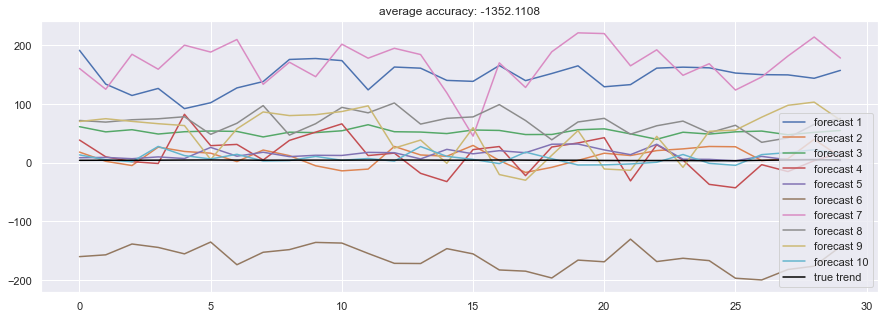

In [10]:
accuracies = [calculate_accuracy(tsla_df['Close'].iloc[-test_size:].values, r) for r in results]
print(results)
plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(tsla_df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
 plt.show()